## Sentiment by source (Source name / Source type)

This notebook compares **nuclear sentiment proportions** across sources using `assignment-E/data/nuclear_mentions_matches.csv`.

- Grouping keys: `Source name`, `Source type`
- Sentiment column: `nuclear_sentiment` (-1 / 0 / 1)


In [1]:
# Parameters
TOP_N_SOURCES = 25     # show top-N source names by number of nuclear-mention statements
MIN_COUNT = 1          # drop sources with fewer than this many nuclear-mention statements

DATA_DIR = "../data"
NUCLEAR_CSV = f"{DATA_DIR}/nuclear_mentions_matches.csv"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)


In [3]:
df = pd.read_csv(NUCLEAR_CSV)

# Normalize types
required = {"nuclear_sentiment", "Source name", "Source type"}
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in nuclear_mentions_matches.csv: {missing}")

df["nuclear_sentiment"] = pd.to_numeric(df["nuclear_sentiment"], errors="coerce")
df["Source name"] = df["Source name"].fillna("(missing source)").astype(str).str.strip()
df["Source type"] = df["Source type"].fillna("(missing type)").astype(str).str.strip()

# Keep only valid sentiment rows
sentiment_order = [-1, 0, 1]
df = df[df["nuclear_sentiment"].isin(sentiment_order)].copy()

df[["id", "Source name", "Source type", "nuclear_sentiment"]].head()

,id,Source name,Source type,nuclear_sentiment
0,8,LinkedIn,Social media,1
1,179,Facebook,Social media,1
2,182,Facebook,Social media,1
3,191,Ekstrabladet,National newspaper,-1
4,193,Facebook,Social media,1


In [4]:
# Filter source names (min count) and pick top-N by volume
source_counts = df["Source name"].value_counts()
sources_kept = source_counts[source_counts >= MIN_COUNT].index

by_source = df[df["Source name"].isin(sources_kept)].copy()

# Top-N source names by number of statements
top_sources = by_source["Source name"].value_counts().head(TOP_N_SOURCES).index
by_source = by_source[by_source["Source name"].isin(top_sources)].copy()

by_source["Source name"].value_counts().head(10)

Source name
Reddit                     126
Facebook                    83
LinkedIn                    33
YouTube                     10
DR                           4
Nordjyske                    3
TerraPower White Paper       3
Viborg Stifts Folkeblad      3
X                            3
Zetland                      3
Name: count, dtype: int64

In [5]:
def sentiment_counts_and_props(df_in: pd.DataFrame, group_col: str):
    sentiment_order = [-1, 0, 1]
    counts = df_in.groupby([group_col, "nuclear_sentiment"]).size().unstack(fill_value=0)
    for s in sentiment_order:
        if s not in counts.columns:
            counts[s] = 0
    counts = counts[sentiment_order]
    props = counts.div(counts.sum(axis=1), axis=0)
    return counts, props


In [6]:
# Sentiment proportions by Source name
source_counts, source_props = sentiment_counts_and_props(by_source, "Source name")

# Sort by positive share (then by volume)
order = source_props[1].sort_values(ascending=False).index
source_props = source_props.loc[order]
source_counts = source_counts.loc[order]

display(source_counts.head(10))
display(source_props.head(10))


nuclear_sentiment,-1,0,1
Source name,,,
Bornholms Tidende,0,0,2
Information,0,0,2
Viborg Stifts Folkeblad,0,0,3
TerraPower White Paper,0,0,3
Stiften,0,0,1
Børsen,0,0,1
Liberal Alliance,0,0,1
Århus Stiftstidende,0,0,2
Holstebro-Struer Dagbladet,0,0,2


nuclear_sentiment,-1,0,1
Source name,,,
Bornholms Tidende,0.0,0.0,1.0
Information,0.0,0.0,1.0
Viborg Stifts Folkeblad,0.0,0.0,1.0
TerraPower White Paper,0.0,0.0,1.0
Stiften,0.0,0.0,1.0
Børsen,0.0,0.0,1.0
Liberal Alliance,0.0,0.0,1.0
Århus Stiftstidende,0.0,0.0,1.0
Holstebro-Struer Dagbladet,0.0,0.0,1.0


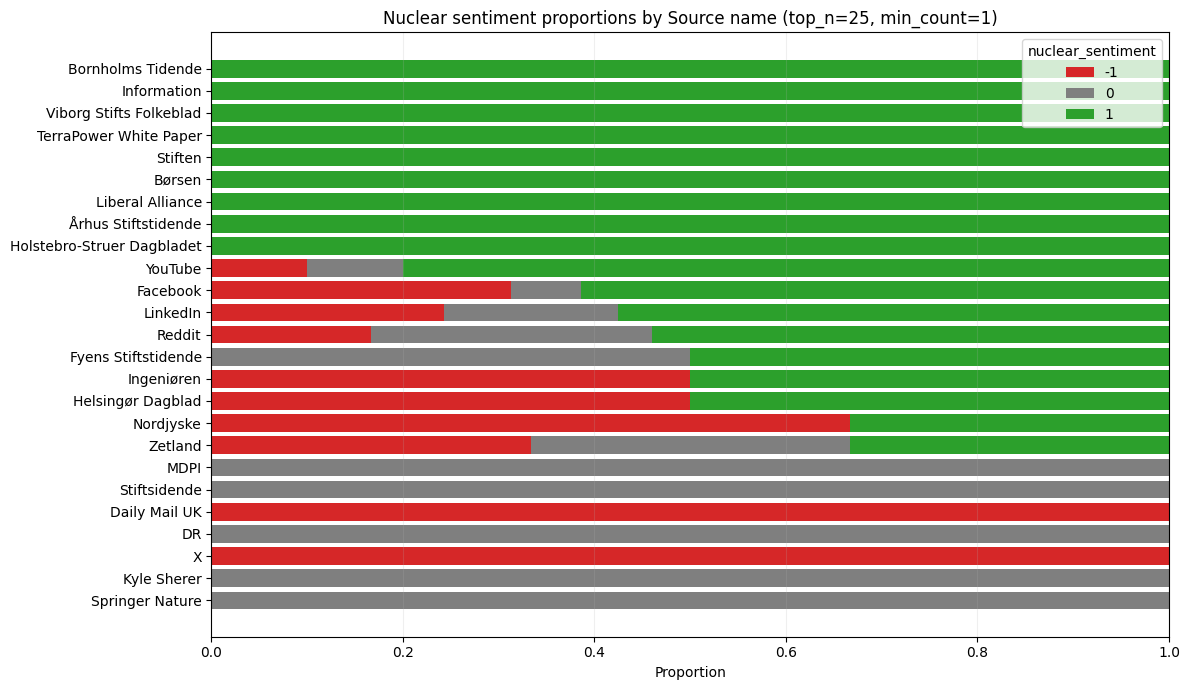

In [7]:
# Plot: stacked sentiment proportions per Source name
fig, ax = plt.subplots(figsize=(12, max(5, 0.28 * len(source_props))))

colors = {-1: "#d62728", 0: "#7f7f7f", 1: "#2ca02c"}

ypos = np.arange(len(source_props))
left = np.zeros(len(source_props))

for s in [-1, 0, 1]:
    ax.barh(ypos, source_props[s].values, left=left, color=colors[s], label=str(s))
    left += source_props[s].values

ax.set_title(f"Nuclear sentiment proportions by Source name (top_n={TOP_N_SOURCES}, min_count={MIN_COUNT})")
ax.set_xlabel("Proportion")
ax.set_xlim(0, 1)
ax.set_yticks(ypos)
ax.set_yticklabels(source_props.index)
ax.invert_yaxis()
ax.legend(title="nuclear_sentiment")
ax.grid(axis="x", alpha=0.2)

plt.tight_layout()
plt.show()


In [8]:
# Sentiment proportions by Source type
# (usually a small number of categories, so no top-N filter needed)
by_type = df.copy()

# Optional: still apply MIN_COUNT to avoid tiny categories
kept_types = by_type["Source type"].value_counts()
kept_types = kept_types[kept_types >= MIN_COUNT].index
by_type = by_type[by_type["Source type"].isin(kept_types)].copy()

type_counts, type_props = sentiment_counts_and_props(by_type, "Source type")

# Sort by positive share
type_order = type_props[1].sort_values(ascending=False).index
type_props = type_props.loc[type_order]
type_counts = type_counts.loc[type_order]

display(type_counts)
display(type_props)


nuclear_sentiment,-1,0,1
Source type,,,
Local news media,0,0,2
NGO website,0,0,1
concerned citizen,0,0,1
Opinion piece,0,0,1
Technical document,0,0,3
Social media,59,50,150
National newspaper,7,8,20
Government website,0,2,1
Civil society report,0,1,0


nuclear_sentiment,-1,0,1
Source type,,,
Local news media,0.000000,0.000000,1.000000
NGO website,0.000000,0.000000,1.000000
concerned citizen,0.000000,0.000000,1.000000
Opinion piece,0.000000,0.000000,1.000000
Technical document,0.000000,0.000000,1.000000
Social media,0.227799,0.193050,0.579151
National newspaper,0.200000,0.228571,0.571429
Government website,0.000000,0.666667,0.333333
Civil society report,0.000000,1.000000,0.000000


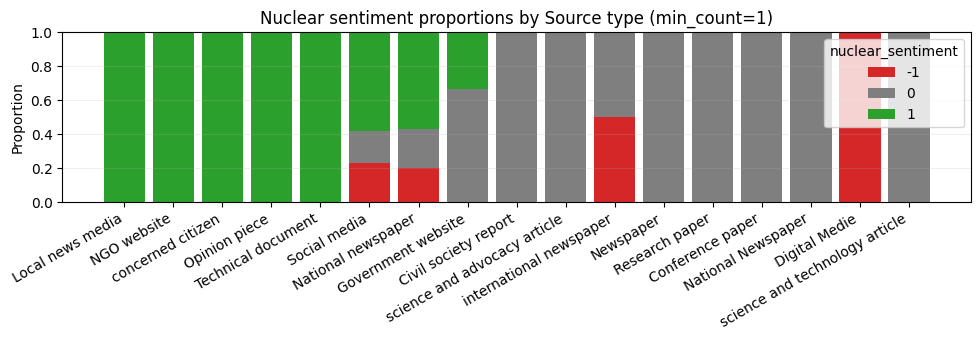

In [9]:
# Plot: stacked sentiment proportions by Source type
fig, ax = plt.subplots(figsize=(10, 3.5))

xpos = np.arange(len(type_props))
bottom = np.zeros(len(type_props))
colors = {-1: "#d62728", 0: "#7f7f7f", 1: "#2ca02c"}

for s in [-1, 0, 1]:
    ax.bar(xpos, type_props[s].values, bottom=bottom, color=colors[s], label=str(s), width=0.85)
    bottom += type_props[s].values

ax.set_title(f"Nuclear sentiment proportions by Source type (min_count={MIN_COUNT})")
ax.set_ylabel("Proportion")
ax.set_ylim(0, 1)
ax.set_xticks(xpos)
ax.set_xticklabels(type_props.index, rotation=30, ha="right")
ax.legend(title="nuclear_sentiment")
ax.grid(axis="y", alpha=0.2)

plt.tight_layout()
plt.show()
